In [1]:
import os
import re
from collections import Counter


In [2]:

# Define the paths to the directories
llama3_dir = "llm_responses/llama3"
mistral_dir = "llm_responses/mistral"

# Function to get the common filename part
def get_common_filename(filename):
    return filename.rsplit('_', 1)[0]

# Function to read the content of a file
def read_file(filepath):
    with open(filepath, 'r') as file:
        return file.read()

# # Function to extract decision from response
# def extract_decision(response):
#     match = re.search(r'^2\) (Don\'t Remove|Do Not Remove|Remove)$', response, re.MULTILINE | re.IGNORECASE)
#     if match:
#         decision = match.group(1).lower()
#         return "Don't Remove" if decision in ["do not remove", "don't remove"] else decision.capitalize()
#     else:
#         return None


# Function to extract decision from response, considering importance score
def extract_decision(response):
    score_match = re.search(r'^\s*1\)\s*Importance Score\s*:\s*(\d+)', response, re.MULTILINE | re.IGNORECASE)
    decision_match = re.search(r'^2\) (Don\'t Remove|Do Not Remove|Remove)$', response, re.MULTILINE | re.IGNORECASE)
 
    if score_match and decision_match:
        importance_score = int(score_match.group(1))
        decision = decision_match.group(1).lower()
        
        if importance_score >= 7 and decision == "remove":
            decision = "don't remove"

        # remove anything below a 5
        if importance_score < 5:
            decision = "remove"
        
        return "Don't Remove" if decision in ["do not remove", "don't remove"] else decision.capitalize()
    else:
        return None

# Function to compare two responses and check if they agree
def compare_responses(response1, response2):
    decision1 = extract_decision(response1)
    decision2 = extract_decision(response2)
    return decision1 == decision2, decision1, decision2
# Function to calculate agreement percentage and separate counts for each decision type
def calculate_agreement_percentage(file_responses):
    total_agreements = 0
    total_files = 0

    decision_counts = Counter()
    decision_agreements = Counter()

    decision_pairs = []
    non_agreement_files = []

    for filename, responses in file_responses.items():
        model_responses = list(responses.values())
        if len(model_responses) == 2:  # Ensure we have responses from both models
            agreement, decision1, decision2 = compare_responses(*model_responses)
            if decision1 and decision2:
                decision_pairs.append((decision1, decision2))
                decision_counts[decision1] += 1
                if agreement:
                    total_agreements += 1
                    decision_agreements[decision1] += 1
                else:
                    non_agreement_files.append(filename)
                total_files += 1

    overall_agreement_percentage = (total_agreements / total_files) * 100 if total_files > 0 else 0
    remove_agreement_percentage = (decision_agreements["Remove"] / decision_counts["Remove"]) * 100 if decision_counts["Remove"] > 0 else 0
    dont_remove_agreement_percentage = (decision_agreements["Don't Remove"] / decision_counts["Don't Remove"]) * 100 if decision_counts["Don't Remove"] > 0 else 0

    return overall_agreement_percentage, remove_agreement_percentage, dont_remove_agreement_percentage, decision_pairs, non_agreement_files


In [3]:

# Get list of files in each directory
llama3_files = os.listdir(llama3_dir)
mistral_files = os.listdir(mistral_dir)

# Create dictionaries to store file paths by their common filename part
llama3_dict = {get_common_filename(f): os.path.join(llama3_dir, f) for f in llama3_files}
mistral_dict = {get_common_filename(f): os.path.join(mistral_dir, f) for f in mistral_files}

# Find common files
common_files = set(llama3_dict.keys()).intersection(set(mistral_dict.keys()))

# Organize responses by file
file_responses = {}

for common_file in common_files:
    llama3_path = llama3_dict[common_file]
    mistral_path = mistral_dict[common_file]
    
    llama3_content = read_file(llama3_path)
    mistral_content = read_file(mistral_path)
    
    file_responses[common_file] = {
        "llama3": llama3_content,
        "mistral": mistral_content
    }

# Calculate agreement percentage and other metrics
overall_agreement_percentage, remove_agreement_percentage, dont_remove_agreement_percentage, decision_pairs, non_agreement_files = calculate_agreement_percentage(file_responses)

# Output the results
print(f"Overall Agreement Percentage: {overall_agreement_percentage:.2f}%")
print(f"Remove Agreement Percentage: {remove_agreement_percentage:.2f}%")
print(f"Don't Remove Agreement Percentage: {dont_remove_agreement_percentage:.2f}%")

# Optional: print decision pairs for further analysis
for pair in decision_pairs:
    print(f"Decision Pair: {pair}")

# Save non-agreement filenames to a .txt file
with open("non_agreement_files.txt", "w") as file:
    for filename in non_agreement_files:
        file.write(f"{filename}\n")

print(f"Non-agreement filenames saved to non_agreement_files.txt")

Overall Agreement Percentage: 83.52%
Remove Agreement Percentage: 79.79%
Don't Remove Agreement Percentage: 84.39%
Decision Pair: ("Don't Remove", 'Remove')
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ('Remove', "Don't Remove")
Decision Pair: ("Don't Remove", 'Remove')
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ('Remove', 'Remove')
Decision Pair: ("Don't Remove", 'Remove')
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ('Remove', 'Remove')
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ("Don't Remove", 'Remove')
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ("Don't Remove", "Don't Remove")
Decision Pair: ('Remove', '

### Make some plots 

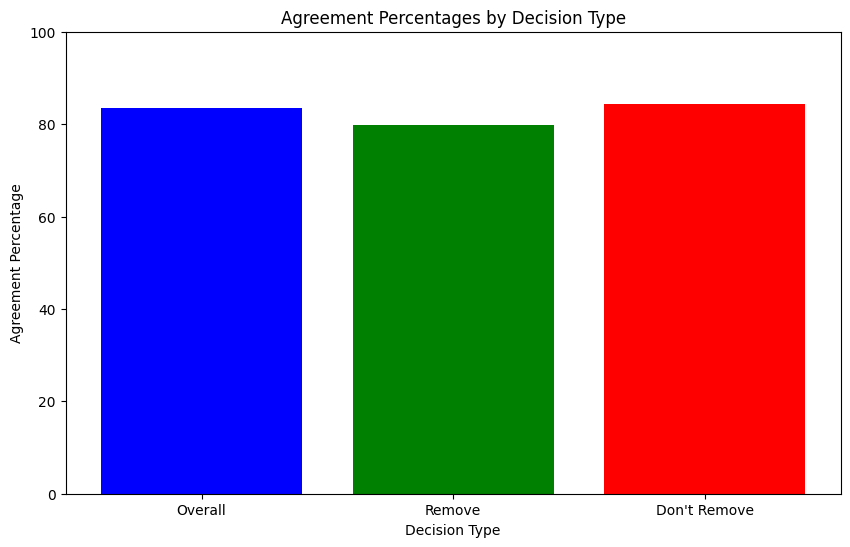

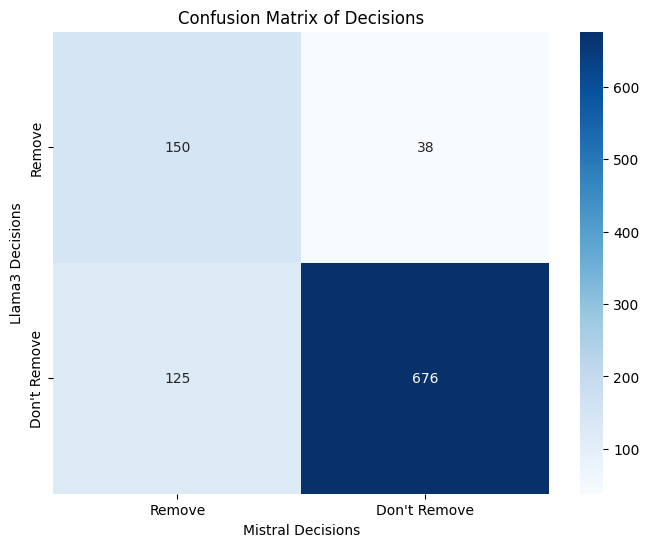

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting agreement percentages
labels = ['Overall', 'Remove', "Don't Remove"]
percentages = [overall_agreement_percentage, remove_agreement_percentage, dont_remove_agreement_percentage]

plt.figure(figsize=(10, 6))
plt.bar(labels, percentages, color=['blue', 'green', 'red'])
plt.xlabel('Decision Type')
plt.ylabel('Agreement Percentage')
plt.title('Agreement Percentages by Decision Type')
plt.ylim(0, 100)
plt.show()

# Creating a confusion matrix
decision_labels = ["Remove", "Don't Remove"]
confusion_matrix = np.zeros((2, 2), int)

for decision1, decision2 in decision_pairs:
    i = decision_labels.index(decision1)
    j = decision_labels.index(decision2)
    confusion_matrix[i, j] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decision_labels, yticklabels=decision_labels)
plt.xlabel('Mistral Decisions')
plt.ylabel('Llama3 Decisions')
plt.title('Confusion Matrix of Decisions')
plt.show()

Agreement Percentage: 83.52%
Cohen's Kappa: 0.55


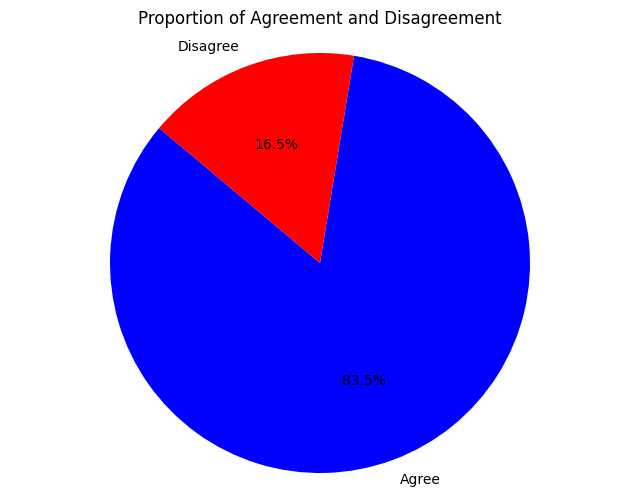

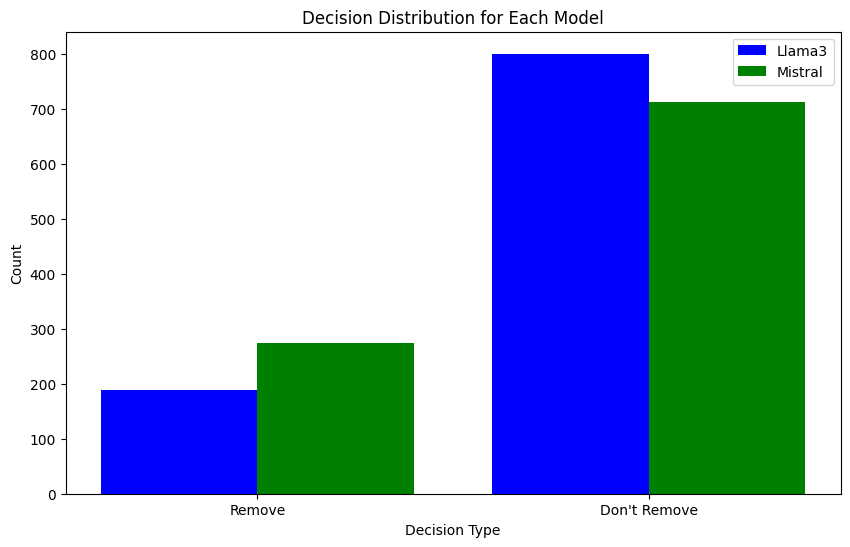

In [5]:
from sklearn.metrics import cohen_kappa_score

# Calculate agreement percentage
total_decisions = len(decision_pairs)
agreement_count = sum(1 for decision1, decision2 in decision_pairs if decision1 == decision2)
agreement_percentage = (agreement_count / total_decisions) * 100

print(f"Agreement Percentage: {agreement_percentage:.2f}%")

# Calculate Cohen's Kappa
model1_predictions = [decision1 for decision1, decision2 in decision_pairs]
model2_predictions = [decision2 for decision1, decision2 in decision_pairs]
kappa = cohen_kappa_score(model1_predictions, model2_predictions)
print(f"Cohen's Kappa: {kappa:.2f}")

agree_count = np.trace(confusion_matrix)
disagree_count = total_decisions - agree_count

labels = ['Agree', 'Disagree']
sizes = [agree_count, disagree_count]
colors = ['blue', 'red']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Agreement and Disagreement')
plt.axis('equal')
plt.show()


model1_decision_counts = [model1_predictions.count(label) for label in decision_labels]
model2_decision_counts = [model2_predictions.count(label) for label in decision_labels]

x = np.arange(len(decision_labels))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, model1_decision_counts, 0.4, label='Llama3', color='blue')
plt.bar(x + 0.2, model2_decision_counts, 0.4, label='Mistral', color='green')
plt.xticks(x, decision_labels)
plt.xlabel('Decision Type')
plt.ylabel('Count')
plt.title('Decision Distribution for Each Model')
plt.legend()
plt.show()


### Importance scores distribution

In [6]:
import os
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# Define the paths to the directories
llama3_dir = "llm_responses/llama3"
mistral_dir = "llm_responses/mistral"

# Function to get the common filename part
def get_common_filename(filename):
    return filename.rsplit('_', 1)[0]

# Function to read the content of a file
def read_file(filepath):
    with open(filepath, 'r') as file:
        return file.read()

# # Function to extract decision from response, considering importance score
# def extract_decision_and_score(response):
#     score_match = re.search(r'^\s*1\)\s*Importance Score\s*:\s*(\d+)', response, re.MULTILINE)
#     decision_match = re.search(r'^\s*2\)\s*(Don\'t Remove|Do Not Remove|Remove)$', response, re.MULTILINE | re.IGNORECASE)
    
#     if score_match and decision_match:
#         importance_score = int(score_match.group(1))
#         decision = decision_match.group(1).lower()
        
#         if importance_score >= 7 and decision == "remove":
#             decision = "don't remove"

#         # remove anything below a 5
#         if importance_score < 5:
#             decision = "remove"
        
#         return ("Don't Remove" if decision in ["do not remove", "don't remove"] else decision.capitalize(), importance_score)
#     else:
#         return (None, None)

# Function to compare two responses and check if they agree
def compare_responses(response1, response2):
    decision1, score1 = extract_decision_and_score(response1)
    decision2, score2 = extract_decision_and_score(response2)
    return decision1 == decision2, decision1, decision2, score1, score2

# Function to calculate agreement percentage and separate counts for each decision type
def calculate_agreement_percentage(file_responses):
    total_agreements = 0
    total_files = 0

    decision_counts = Counter()
    decision_agreements = Counter()
    
    decision_pairs = []
    non_agreement_files = []

    llama3_scores = []
    mistral_scores = []

    for filename, responses in file_responses.items():
        model_responses = list(responses.values())
        if len(model_responses) == 2:  # Ensure we have responses from both models
            agreement, decision1, decision2, score1, score2 = compare_responses(*model_responses)
            if decision1 and decision2:
                decision_pairs.append((decision1, decision2))
                decision_counts[decision1] += 1
                if agreement:
                    total_agreements += 1
                    decision_agreements[decision1] += 1
                else:
                    non_agreement_files.append(filename)
                total_files += 1

            if score1 is not None:
                llama3_scores.append((score1, decision1))
            if score2 is not None:
                mistral_scores.append((score2, decision2))

    overall_agreement_percentage = (total_agreements / total_files) * 100 if total_files > 0 else 0
    remove_agreement_percentage = (decision_agreements["Remove"] / decision_counts["Remove"]) * 100 if decision_counts["Remove"] > 0 else 0
    dont_remove_agreement_percentage = (decision_agreements["Don't Remove"] / decision_counts["Don't Remove"]) * 100 if decision_counts["Don't Remove"] > 0 else 0

    return overall_agreement_percentage, remove_agreement_percentage, dont_remove_agreement_percentage, decision_pairs, non_agreement_files, llama3_scores, mistral_scores

# Function to count decisions at each importance score
def count_decisions_at_scores(scores):
    count_dict = defaultdict(lambda: {'Remove': 0, 'Don\'t Remove': 0})
    
    for score, decision in scores:
        if decision in count_dict[score]:
            count_dict[score][decision] += 1

    return count_dict

# Get list of files in each directory
llama3_files = os.listdir(llama3_dir)
mistral_files = os.listdir(mistral_dir)

# Create dictionaries to store file paths by their common filename part
llama3_dict = {get_common_filename(f): os.path.join(llama3_dir, f) for f in llama3_files}
mistral_dict = {get_common_filename(f): os.path.join(mistral_dir, f) for f in mistral_files}

# Find common files
common_files = set(llama3_dict.keys()).intersection(set(mistral_dict.keys()))

# Organize responses by file
file_responses = {}

for common_file in common_files:
    llama3_path = llama3_dict[common_file]
    mistral_path = mistral_dict[common_file]
    
    llama3_content = read_file(llama3_path)
    mistral_content = read_file(mistral_path)
    
    file_responses[common_file] = {
        "llama3": llama3_content,
        "mistral": mistral_content
    }

# Calculate agreement percentage and other metrics
overall_agreement_percentage, remove_agreement_percentage, dont_remove_agreement_percentage, decision_pairs, non_agreement_files, llama3_scores, mistral_scores = calculate_agreement_percentage(file_responses)

# Output the results
print(f"Overall Agreement Percentage: {overall_agreement_percentage:.2f}%")
print(f"Remove Agreement Percentage: {remove_agreement_percentage:.2f}%")
print(f"Don't Remove Agreement Percentage: {dont_remove_agreement_percentage:.2f}%")

# Optional: print decision pairs for further analysis
for pair in decision_pairs:
    print(f"Decision Pair: {pair}")

# Save non-agreement filenames to a .txt file
with open("non_agreement_files.txt", "w") as file:
    for filename in non_agreement_files:
        file.write(f"{filename}\n")

print(f"Non-agreement filenames saved to non_agreement_files.txt")

# Count decisions at each importance score
llama3_decision_counts = count_decisions_at_scores(llama3_scores)
mistral_decision_counts = count_decisions_at_scores(mistral_scores)

# Print decision counts for analysis
print("Llama3 Decision Counts at Each Importance Score:")
for score, counts in sorted(llama3_decision_counts.items()):
    print(f"Importance Score {score}: {counts}")

print("Mistral Decision Counts at Each Importance Score:")
for score, counts in sorted(mistral_decision_counts.items()):
    print(f"Importance Score {score}: {counts}")

# Plot the distribution of importance scores
def plot_score_distribution(decision_counts, model_name):
    scores = sorted(decision_counts.keys())
    remove_counts = [decision_counts[score]['Remove'] for score in scores]
    dont_remove_counts = [decision_counts[score]['Don\'t Remove'] for score in scores]

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(scores))

    plt.bar(index, remove_counts, bar_width, label='Remove', color='red', alpha=0.7)
    plt.bar([i + bar_width for i in index], dont_remove_counts, bar_width, label='Don\'t Remove', color='green', alpha=0.7)

    plt.xlabel('Importance Score')
    plt.ylabel('Frequency')
    plt.title(f'Importance Score Distribution for {model_name}')
    plt.xticks([i + bar_width / 2 for i in index], scores)
    plt.legend()
    plt.show()

# Plot distributions for both models
plot_score_distribution(llama3_decision_counts, "Llama3")
plot_score_distribution(mistral_decision_counts, "Mistral")


NameError: name 'extract_decision_and_score' is not defined

Overall Agreement Percentage: 83.32%
Remove Agreement Percentage: 1.64%
Don't Remove Agreement Percentage: 94.81%
Non-agreement filenames saved to non_agreement_files.txt
Llama3 Decision Counts at Each Importance Score:
Importance Score 2: {'Remove': 6, "Don't Remove": 97}
Importance Score 4: {'Remove': 3, "Don't Remove": 59}
Importance Score 5: {'Remove': 5, "Don't Remove": 91}
Importance Score 6: {'Remove': 19, "Don't Remove": 95}
Importance Score 7: {'Remove': 32, "Don't Remove": 173}
Importance Score 8: {'Remove': 57, "Don't Remove": 353}
Mistral Decision Counts at Each Importance Score:
Importance Score 1: {'Remove': 19, "Don't Remove": 56}
Importance Score 2: {'Remove': 21, "Don't Remove": 146}
Importance Score 3: {'Remove': 0, "Don't Remove": 21}
Importance Score 4: {'Remove': 1, "Don't Remove": 11}
Importance Score 5: {'Remove': 0, "Don't Remove": 128}
Importance Score 6: {'Remove': 0, "Don't Remove": 3}
Importance Score 7: {'Remove': 1, "Don't Remove": 82}
Importance Score 8: 

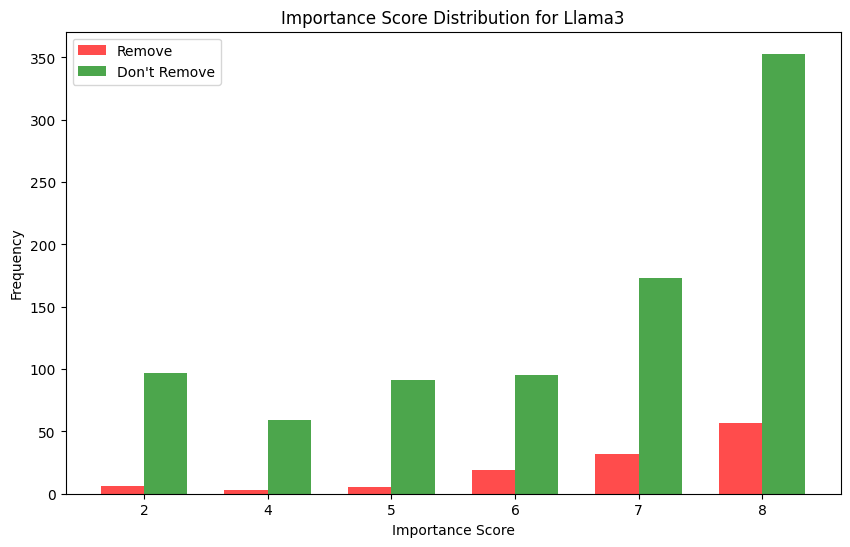

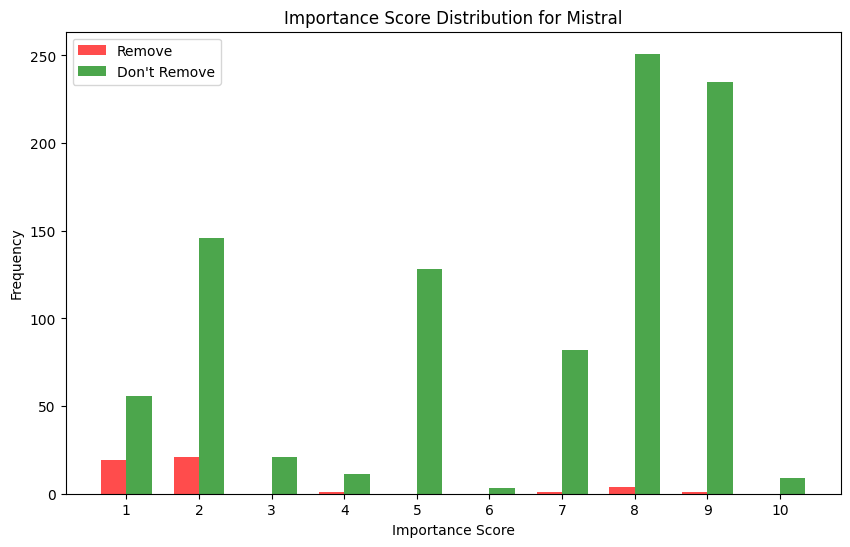

Copied removed_code_C2_778_time_16-22-33-314.blade.c to llm_responses/llama3/importance_8
Copied removed_code_C2_175_time_16-20-18-167.blade.c to llm_responses/llama3/importance_2
Copied removed_code_C2_468_time_16-21-30-958.blade.c to llm_responses/llama3/importance_7
Copied removed_code_C2_794_time_16-22-35-789.blade.c to llm_responses/llama3/importance_2
Copied removed_code_C2_186_time_16-20-20-850.blade.c to llm_responses/llama3/importance_2
Copied removed_code_C1_812_time_16-22-38-189.blade.c to llm_responses/llama3/importance_8
Copied removed_code_C2_798_time_16-22-36-322.blade.c to llm_responses/llama3/importance_8
Copied removed_code_C2_710_time_16-22-22-654.blade.c to llm_responses/llama3/importance_7
Copied removed_code_C2_280_time_16-20-45-253.blade.c to llm_responses/llama3/importance_7
Copied removed_code_C2_266_time_16-20-39-446.blade.c to llm_responses/llama3/importance_2
Copied removed_code_C2_83_time_16-19-51-856.blade.c to llm_responses/llama3/importance_8
Copied remo

In [ ]:
# import os
# import re
# from collections import Counter, defaultdict
# import shutil
# import matplotlib.pyplot as plt

# # Define the paths to the directories
# llama3_dir = "llm_responses/llama3"
# mistral_dir = "llm_responses/mistral"

# # Function to get the common filename part
# def get_common_filename(filename):
#     return filename.rsplit('_', 1)[0]

# # Function to read the content of a file
# def read_file(filepath):
#     with open(filepath, 'r') as file:
#         return file.read()

# # Function to extract decision from response, considering importance score
# def extract_decision_and_score(response):
#     score_match = re.search(r'^\s*1\)\s*Importance Score\s*:\s*(\d+)', response, re.MULTILINE)
#     decision_match = re.search(r'^\s*2\)\s*(Don\'t Remove|Do Not Remove|Remove)$', response, re.MULTILINE | re.IGNORECASE)
    
#     if score_match and decision_match:
#         importance_score = int(score_match.group(1))
#         decision = decision_match.group(1).lower()
        
#         return ("Don't Remove" if decision in ["do not remove", "don't remove"] else decision.capitalize(), importance_score)
#     else:
#         return (None, None)

# # Function to compare two responses and check if they agree
# def compare_responses(response1, response2):
#     decision1, score1 = extract_decision_and_score(response1)
#     decision2, score2 = extract_decision_and_score(response2)
#     return decision1 == decision2, decision1, decision2, score1, score2

# # Function to calculate agreement percentage and separate counts for each decision type
# def calculate_agreement_percentage(file_responses):
#     total_agreements = 0
#     total_files = 0

#     decision_counts = Counter()
#     decision_agreements = Counter()
    
#     decision_pairs = []
#     non_agreement_files = []

#     llama3_scores = []
#     mistral_scores = []

#     for filename, responses in file_responses.items():
#         model_responses = list(responses.values())
#         if len(model_responses) == 2:  # Ensure we have responses from both models
#             agreement, decision1, decision2, score1, score2 = compare_responses(*model_responses)
#             if decision1 and decision2:
#                 decision_pairs.append((decision1, decision2))
#                 decision_counts[decision1] += 1
#                 if agreement:
#                     total_agreements += 1
#                     decision_agreements[decision1] += 1
#                 else:
#                     non_agreement_files.append(filename)
#                 total_files += 1

#             if score1 is not None:
#                 llama3_scores.append((score1, decision1))
#             if score2 is not None:
#                 mistral_scores.append((score2, decision2))

#     overall_agreement_percentage = (total_agreements / total_files) * 100 if total_files > 0 else 0
#     remove_agreement_percentage = (decision_agreements["Remove"] / decision_counts["Remove"]) * 100 if decision_counts["Remove"] > 0 else 0
#     dont_remove_agreement_percentage = (decision_agreements["Don't Remove"] / decision_counts["Don't Remove"]) * 100 if decision_counts["Don't Remove"] > 0 else 0

#     return overall_agreement_percentage, remove_agreement_percentage, dont_remove_agreement_percentage, decision_pairs, non_agreement_files, llama3_scores, mistral_scores

# # Function to count decisions at each importance score
# def count_decisions_at_scores(scores):
#     count_dict = defaultdict(lambda: {'Remove': 0, 'Don\'t Remove': 0})
    
#     for score, decision in scores:
#         if decision in count_dict[score]:
#             count_dict[score][decision] += 1

#     return count_dict

# # Function to create directories and copy files based on importance scores
# def organize_files_by_score(scores, model_dir, model_name):
#     score_dirs = {}
    
#     for score, _ in scores:
#         score_dir = os.path.join(model_dir, f"importance_{score}")
#         if score_dir not in score_dirs:
#             os.makedirs(score_dir, exist_ok=True)
#             score_dirs[score] = score_dir

#     for filename in common_files:
#         common_name = filename
#         # common_name = get_common_filename(filename)
#         # print(common_name)
#         if common_name in file_responses:
#             response = file_responses[common_name][model_name]
#             _, file_score = extract_decision_and_score(response)
#             if file_score in score_dirs:
#                 shutil.copyfile(os.path.join(model_dir, f"{filename}_{model_name}.txt"), os.path.join(score_dirs[file_score], f"{filename}_{model_name}.txt"))
#                 print(f"Copied {filename} to {score_dirs[file_score]}")

# # Get list of files in each directory
# llama3_files = os.listdir(llama3_dir)
# mistral_files = os.listdir(mistral_dir)

# # Create dictionaries to store file paths by their common filename part
# llama3_dict = {get_common_filename(f): os.path.join(llama3_dir, f) for f in llama3_files}
# mistral_dict = {get_common_filename(f): os.path.join(mistral_dir, f) for f in mistral_files}

# # Find common files
# common_files = set(llama3_dict.keys()).intersection(set(mistral_dict.keys()))

# # Organize responses by file
# file_responses = {}

# for common_file in common_files:
#     llama3_path = llama3_dict[common_file]
#     mistral_path = mistral_dict[common_file]
    
#     llama3_content = read_file(llama3_path)
#     mistral_content = read_file(mistral_path)
    
#     file_responses[common_file] = {
#         "llama3": llama3_content,
#         "mistral": mistral_content
#     }

# # Calculate agreement percentage and other metrics
# overall_agreement_percentage, remove_agreement_percentage, dont_remove_agreement_percentage, decision_pairs, non_agreement_files, llama3_scores, mistral_scores = calculate_agreement_percentage(file_responses)

# # Output the results
# print(f"Overall Agreement Percentage: {overall_agreement_percentage:.2f}%")
# print(f"Remove Agreement Percentage: {remove_agreement_percentage:.2f}%")
# print(f"Don't Remove Agreement Percentage: {dont_remove_agreement_percentage:.2f}%")

# # Optional: print decision pairs for further analysis
# # for pair in decision_pairs:
# #     print(f"Decision Pair: {pair}")

# # Save non-agreement filenames to a .txt file
# with open("non_agreement_files.txt", "w") as file:
#     for filename in non_agreement_files:
#         file.write(f"{filename}\n")

# print(f"Non-agreement filenames saved to non_agreement_files.txt")

# # Count decisions at each importance score
# llama3_decision_counts = count_decisions_at_scores(llama3_scores)
# mistral_decision_counts = count_decisions_at_scores(mistral_scores)

# # Print decision counts for analysis
# print("Llama3 Decision Counts at Each Importance Score:")
# for score, counts in sorted(llama3_decision_counts.items()):
#     print(f"Importance Score {score}: {counts}")

# print("Mistral Decision Counts at Each Importance Score:")
# for score, counts in sorted(mistral_decision_counts.items()):
#     print(f"Importance Score {score}: {counts}")

# # Plot the distribution of importance scores
# def plot_score_distribution(decision_counts, model_name):
#     scores = sorted(decision_counts.keys())
#     remove_counts = [decision_counts[score]['Remove'] for score in scores]
#     dont_remove_counts = [decision_counts[score]['Don\'t Remove'] for score in scores]

#     plt.figure(figsize=(10, 6))
#     bar_width = 0.35
#     index = range(len(scores))

#     plt.bar(index, remove_counts, bar_width, label='Remove', color='red', alpha=0.7)
#     plt.bar([i + bar_width for i in index], dont_remove_counts, bar_width, label='Don\'t Remove', color='green', alpha=0.7)

#     plt.xlabel('Importance Score')
#     plt.ylabel('Frequency')
#     plt.title(f'Importance Score Distribution for {model_name}')
#     plt.xticks([i + bar_width / 2 for i in index], scores)
#     plt.legend()
#     plt.show()

# # Plot distributions for both models
# plot_score_distribution(llama3_decision_counts, "Llama3")
# plot_score_distribution(mistral_decision_counts, "Mistral")

# # Organize files into directories based on importance scores
# organize_files_by_score(llama3_scores, llama3_dir, "llama3")
# organize_files_by_score(mistral_scores, mistral_dir, "mistral")

# print("Files organized into directories based on importance scores.")


### Comparison with LLVM Coverage

In [11]:
def extract_coverage(file_path):

    with open(file_path, 'r') as file:
        text = file.read()

    match = re.search(r"Candidate set exist in coverage\?:\s*(True|False)", text, re.IGNORECASE)
    if match:
        exists = match.group(1)
        return exists.lower() == "true"
    else:
        return None

# Function to get the common filename part
def get_name(filename):
    return f"{filename.rsplit('_', 1)[0][:-2]}.txt"

# Get list of files in each directory

# gpt3.5 file path
gpt3_5_dir = "llm_responses/gpt_3.5"

files_list = os.listdir(gpt3_5_dir)
files_list.sort()
# print(files_list)

# coverage list
coverage_list = []
for each in files_list:
    coverage = extract_coverage(os.path.join(gpt3_5_dir, each))
    coverage_list.append(coverage)

covered_count = coverage_list.count(True)
not_covered_count = coverage_list.count(False)

gpt_decisions = []
for each in files_list:
    text = read_file(os.path.join(gpt3_5_dir, each))
    decision = extract_decision(text)
    gpt_decisions.append(decision)

gpt_decisions_dict = {}
for i in range(len(coverage_list)):
    gpt_decisions_dict[files_list[i]] = {"Decision": gpt_decisions[i], "Coverage": coverage_list[i]}


# llama path
llama_dir = "llm_responses/llama3"
llama3_files = os.listdir(llama_dir)
llama3_files.sort()

llama_decisions = []
# get decision from all models directory
for each in llama3_files:
    text = read_file(os.path.join(llama_dir, each))
    decision = extract_decision(text)
    llama_decisions.append(decision)

llama_decisions_dict = {}
for i in range(len(coverage_list)):
    llama_decisions_dict[get_name(llama3_files[i])] = {"Decision": llama_decisions[i], "Coverage": coverage_list[i]}

# mistral path
mistral_dir = "llm_responses/mistral"
mistral_files = os.listdir(mistral_dir)
mistral_files.sort()

mistral_decisions = []
# get decision from all models directory
for each in mistral_files:
    text = read_file(os.path.join(mistral_dir, each))
    decision = extract_decision(text)
    if decision == None: 
        decision = "Don't Remove"
    mistral_decisions.append(decision)

mistral_decisions_dict = {}
for i in range(len(coverage_list)):
    mistral_decisions_dict[get_name(mistral_files[i])] = {"Decision": mistral_decisions[i], "Coverage": coverage_list[i]}


mixtral_dir = "llm_responses/mixtral8x7b"
mixtral_files = os.listdir(mixtral_dir)
mixtral_files.sort()

mixtral_decisions = []
# get decision from all models directory
for each in mixtral_files:
    text = read_file(os.path.join(mixtral_dir, each))
    decision = extract_decision(text)
    if decision == None: 
        decision = "Don't Remove"
    mixtral_decisions.append(decision)

mixtral_decisions_dict = {}
for i in range(len(coverage_list)):
    mixtral_decisions_dict[get_name(mixtral_files[i])] = {"Decision": mixtral_decisions[i], "Coverage": coverage_list[i]}

# print(set(mistral_decisions))

def compare_decisions(model_decisions, coverage_list):
    agreement_count = 0
    remove_covered = 0
    remove_not_covered = 0
    dont_remove_covered = 0
    dont_remove_not_covered = 0
    # check if mistral decisions match with coverage, True -> Don't Remove, False -> Remove
    for i in range(len(model_decisions)):
        if model_decisions[i] == "Don't Remove" and coverage_list[i] == True:
            agreement_count += 1
            dont_remove_covered += 1
        elif model_decisions[i] == "Remove" and coverage_list[i] == False:
            agreement_count += 1
            remove_not_covered += 1
        elif model_decisions[i] == "Remove" and coverage_list[i] == True:
            remove_covered += 1
        elif model_decisions[i] == "Don't Remove" and coverage_list[i] == False:
            dont_remove_not_covered += 1
    
    return agreement_count, remove_covered, remove_not_covered, dont_remove_covered, dont_remove_not_covered

print("\nTotal Candidate Sets:", len(coverage_list))
print("Covered Candidate Sets:", covered_count)
print("Not Covered Candidate Sets:", not_covered_count)

# llama results 
llama_agreement_count, llama_remove_covered, llama_remove_not_covered, llama_dont_remove_covered, llama_dont_remove_not_covered = compare_decisions(llama_decisions, coverage_list)
total_decisions = len(coverage_list)
agreement_percentage = (llama_agreement_count / total_decisions) * 100

print("\nLlama3 Results")
print(f"Agreement Percentage: {agreement_percentage:.2f}%")
print(f"Percentage of covered sets being kept: {(llama_dont_remove_covered / covered_count) * 100:.2f}%")
print(f"Percentage of not covered sets being removed: {(llama_remove_not_covered / not_covered_count) * 100:.2f}%")
print(f"Removed sets that are not in coverage: {llama_remove_not_covered}")
print(f"Removed sets that are in coverage: {llama_remove_covered}")
print(f"Kept sets that are in coverage: {llama_dont_remove_covered}")
print(f"Kept sets that are not in coverage: {llama_dont_remove_not_covered}")
print(f"Perecentage of covered sets being kept: {(llama_dont_remove_covered / covered_count) * 100:.2f}%")


# mistral results
mistral_agreement_count, mistral_remove_covered, mistral_remove_not_covered, mistral_dont_remove_covered, mistral_dont_remove_not_covered = compare_decisions(mistral_decisions, coverage_list)
agreement_percentage = (mistral_agreement_count / total_decisions) * 100

print("\nMistral Results")
print(f"Agreement Percentage: {agreement_percentage:.2f}%")
print(f"Percentage of covered sets being kept: {(mistral_dont_remove_covered / covered_count) * 100:.2f}%")
print(f"Percentage of not covered sets being removed: {(mistral_remove_not_covered / not_covered_count) * 100:.2f}%")
print(f"Removed sets that are not in coverage: {mistral_remove_not_covered}")
print(f"Removed sets that are in coverage: {mistral_remove_covered}")
print(f"Kept sets that are in coverage: {mistral_dont_remove_covered}")
print(f"Kept sets that are not in coverage: {mistral_dont_remove_not_covered}")

# gpt3.5 results
gpt_agreement_count, gpt_remove_covered, gpt_remove_not_covered, gpt_dont_remove_covered, gpt_dont_remove_not_covered = compare_decisions(gpt_decisions, coverage_list)
agreement_percentage = (gpt_agreement_count / total_decisions) * 100

print("\nGPT-3.5 Results")
print(f"Agreement Percentage: {agreement_percentage:.2f}%")
print(f"Percentage of covered sets being kept: {(gpt_dont_remove_covered / covered_count) * 100:.2f}%")
print(f"Percentage of not covered sets being removed: {(gpt_remove_not_covered / not_covered_count) * 100:.2f}%")
print(f"Removed sets that are not in coverage: {gpt_remove_not_covered}")
print(f"Removed sets that are in coverage: {gpt_remove_covered}")
print(f"Kept sets that are in coverage: {gpt_dont_remove_covered}")
print(f"Kept sets that are not in coverage: {gpt_dont_remove_not_covered}")

# mixtral results
mixtral_agreement_count, mixtral_remove_covered, mixtral_remove_not_covered, mixtral_dont_remove_covered, mixtral_dont_remove_not_covered = compare_decisions(mixtral_decisions, coverage_list)
agreement_percentage = (mixtral_agreement_count / total_decisions) * 100

print("\nMixtral Results")
print(f"Agreement Percentage: {agreement_percentage:.2f}%")
print(f"Percentage of covered sets being kept: {(mixtral_dont_remove_covered / covered_count) * 100:.2f}%")
print(f"Percentage of not covered sets being removed: {(mixtral_remove_not_covered / not_covered_count) * 100:.2f}%")
print(f"Removed sets that are not in coverage: {mixtral_remove_not_covered}")
print(f"Removed sets that are in coverage: {mixtral_remove_covered}")
print(f"Kept sets that are in coverage: {mixtral_dont_remove_covered}")
print(f"Kept sets that are not in coverage: {mixtral_dont_remove_not_covered}")


Total Candidate Sets: 990
Covered Candidate Sets: 864
Not Covered Candidate Sets: 126

Llama3 Results
Agreement Percentage: 70.61%
Percentage of covered sets being kept: 79.51%
Percentage of not covered sets being removed: 9.52%
Removed sets that are not in coverage: 12
Removed sets that are in coverage: 177
Kept sets that are in coverage: 687
Kept sets that are not in coverage: 114
Perecentage of covered sets being kept: 79.51%

Mistral Results
Agreement Percentage: 65.35%
Percentage of covered sets being kept: 71.53%
Percentage of not covered sets being removed: 23.02%
Removed sets that are not in coverage: 29
Removed sets that are in coverage: 246
Kept sets that are in coverage: 618
Kept sets that are not in coverage: 97

GPT-3.5 Results
Agreement Percentage: 72.42%
Percentage of covered sets being kept: 79.63%
Percentage of not covered sets being removed: 23.02%
Removed sets that are not in coverage: 29
Removed sets that are in coverage: 176
Kept sets that are in coverage: 688
Kep

In [12]:
# from pprint import pprint

# overall_agreement = 0
# all_agreement_removal = 0
# all_agreement_dont_removal = 0
# mistral_llama_agreement = 0
# mistral_gpt_agreement = 0
# llama_gpt_agreement = 0
# for key,val in llama_decisions_dict.items():
#     if val == mistral_decisions_dict[key] == gpt_decisions_dict[key]:
#         overall_agreement += 1
#     if val == mistral_decisions_dict[key] == gpt_decisions_dict[key] and val['Decision'] == 'Remove':
#         all_agreement_removal += 1
#     if val == mistral_decisions_dict[key] == gpt_decisions_dict[key] and val['Decision'] == "Don't Remove":
#         all_agreement_dont_removal += 1
#     if val == mistral_decisions_dict[key]:
#         mistral_llama_agreement += 1
#     if val == gpt_decisions_dict[key]:
#         llama_gpt_agreement += 1
#     if mistral_decisions_dict[key] == gpt_decisions_dict[key]:
#         mistral_gpt_agreement += 1    

# print(f"All Agreement Removals: {all_agreement_removal}")
# print(f"All Agreement Don't Removals: {all_agreement_dont_removal}")
# print(f"Overall Agreement Percentage: {(overall_agreement / total_decisions) * 100 :.2f}%")
# print(f"Mistral and Llama3 Agreement Percentage: {(mistral_llama_agreement / total_decisions) * 100 :.2f}%")
# print(f"Mistral and GPT-3.5 Agreement Percentage: {(mistral_gpt_agreement / total_decisions) * 100 :.2f}%")
# print(f"Llama3 and GPT-3.5 Agreement Percentage: {(llama_gpt_agreement / total_decisions) * 100 :.2f}%")


from pprint import pprint

overall_agreement = 0
all_agreement_removal = 0
all_agreement_dont_removal = 0
mistral_llama_agreement = 0
mistral_gpt_agreement = 0
llama_gpt_agreement = 0
for key,val in llama_decisions_dict.items():
    if val == mistral_decisions_dict[key] == mixtral_decisions_dict[key]:
        overall_agreement += 1
    if val == mistral_decisions_dict[key] == mixtral_decisions_dict[key] and val['Decision'] == 'Remove':
        all_agreement_removal += 1
    if val == mistral_decisions_dict[key] == mixtral_decisions_dict[key] and val['Decision'] == "Don't Remove":
        all_agreement_dont_removal += 1
    if val == mistral_decisions_dict[key]:
        mistral_llama_agreement += 1
    if val == mixtral_decisions_dict[key]:
        llama_gpt_agreement += 1
    if mistral_decisions_dict[key] == mixtral_decisions_dict[key]:
        mistral_gpt_agreement += 1    

print(f"All Agreement Removals: {all_agreement_removal}")
print(f"All Agreement Don't Removals: {all_agreement_dont_removal}")
print(f"Overall Agreement Percentage: {(overall_agreement / total_decisions) * 100 :.2f}%")
print(f"Mistral and Llama3 Agreement Percentage: {(mistral_llama_agreement / total_decisions) * 100 :.2f}%")
print(f"Mistral and Mixtral Agreement Percentage: {(mistral_gpt_agreement / total_decisions) * 100 :.2f}%")
print(f"Llama3 and Mixtral Agreement Percentage: {(llama_gpt_agreement / total_decisions) * 100 :.2f}%")





All Agreement Removals: 131
All Agreement Don't Removals: 653
Overall Agreement Percentage: 79.19%
Mistral and Llama3 Agreement Percentage: 83.43%
Mistral and Mixtral Agreement Percentage: 89.70%
Llama3 and Mixtral Agreement Percentage: 85.25%


## Pairwise agreement confusion matrices

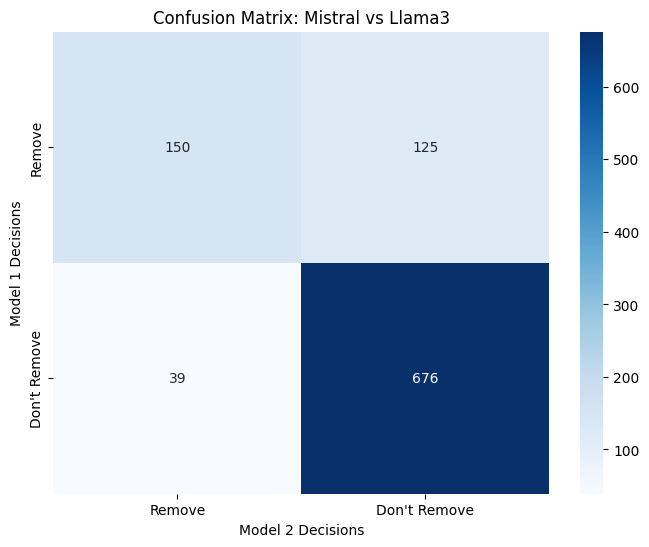

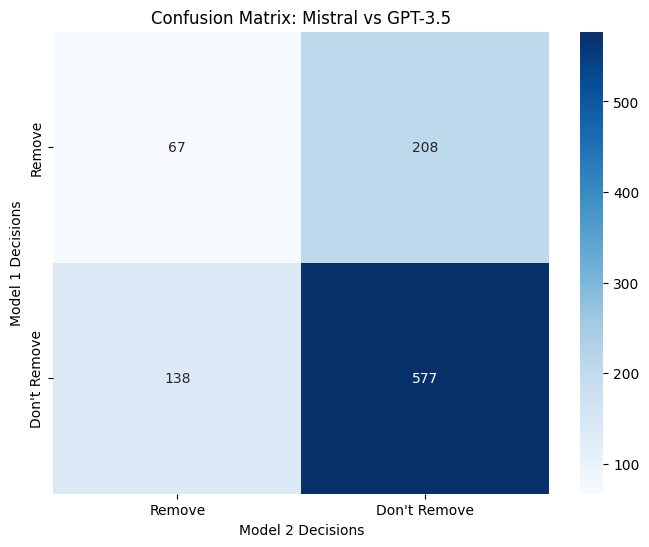

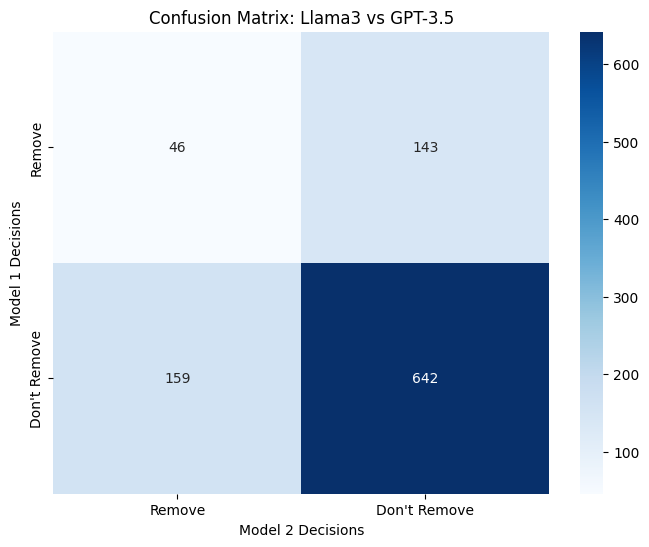

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

decision_labels = ["Remove", "Don't Remove"]

# Initialize confusion matrices
confusion_matrices = {
    'Mistral vs Llama3': np.zeros((2, 2), int),
    'Mistral vs GPT-3.5': np.zeros((2, 2), int),
    'Llama3 vs GPT-3.5': np.zeros((2, 2), int)
}

# Populate confusion matrices
for key in llama_decisions_dict:
    llama_decision = llama_decisions_dict[key]['Decision']
    mistral_decision = mistral_decisions_dict[key]['Decision']
    gpt_decision = gpt_decisions_dict[key]['Decision']

    # Mistral vs Llama3
    confusion_matrices['Mistral vs Llama3'][decision_labels.index(mistral_decision), decision_labels.index(llama_decision)] += 1

    # Mistral vs GPT-3.5
    confusion_matrices['Mistral vs GPT-3.5'][decision_labels.index(mistral_decision), decision_labels.index(gpt_decision)] += 1

    # Llama3 vs GPT-3.5
    confusion_matrices['Llama3 vs GPT-3.5'][decision_labels.index(llama_decision), decision_labels.index(gpt_decision)] += 1

# Plot confusion matrices
for title, matrix in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decision_labels, yticklabels=decision_labels)
    plt.xlabel('Model 2 Decisions')
    plt.ylabel('Model 1 Decisions')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()


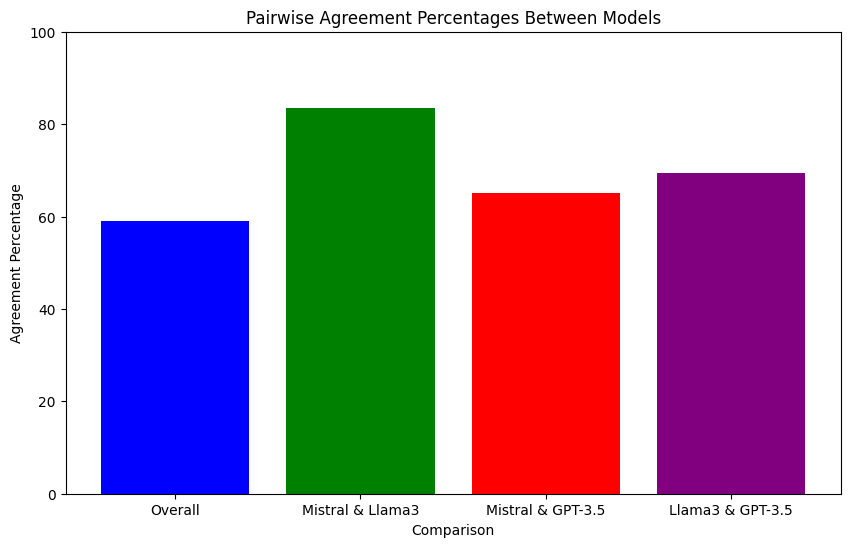

In [ ]:
agreement_labels = ['Overall', 'Mistral & Llama3', 'Mistral & GPT-3.5', 'Llama3 & GPT-3.5']
agreement_percentages = [
    (overall_agreement / total_decisions) * 100,
    (mistral_llama_agreement / total_decisions) * 100,
    (mistral_gpt_agreement / total_decisions) * 100,
    (llama_gpt_agreement / total_decisions) * 100
]

plt.figure(figsize=(10, 6))
plt.bar(agreement_labels, agreement_percentages, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Comparison')
plt.ylabel('Agreement Percentage')
plt.title('Pairwise Agreement Percentages Between Models')
plt.ylim(0, 100)
plt.show()


In [ ]:
disagreement_cases = []

for key in llama_decisions_dict:
    llama_decision = llama_decisions_dict[key]['Decision']
    mistral_decision = mistral_decisions_dict[key]['Decision']
    gpt_decision = gpt_decisions_dict[key]['Decision']
    
    if not (llama_decision == mistral_decision == gpt_decision):
        disagreement_cases.append({
            'File': key,
            'Llama3': llama_decision,
            'Mistral': mistral_decision,
            'GPT-3.5': gpt_decision,
            'Coverage': llama_decisions_dict[key]['Coverage']
        })

pprint((disagreement_cases))


[{'Coverage': True,
  'File': 'removed_code_C1_0_time_16-19-26-300.blade.txt',
  'GPT-3.5': 'Remove',
  'Llama3': "Don't Remove",
  'Mistral': "Don't Remove"},
 {'Coverage': True,
  'File': 'removed_code_C1_100_time_16-19-58-592.blade.txt',
  'GPT-3.5': 'Remove',
  'Llama3': "Don't Remove",
  'Mistral': "Don't Remove"},
 {'Coverage': True,
  'File': 'removed_code_C1_102_time_16-19-59-026.blade.txt',
  'GPT-3.5': 'Remove',
  'Llama3': 'Remove',
  'Mistral': "Don't Remove"},
 {'Coverage': True,
  'File': 'removed_code_C1_104_time_16-19-59-453.blade.txt',
  'GPT-3.5': 'Remove',
  'Llama3': "Don't Remove",
  'Mistral': "Don't Remove"},
 {'Coverage': False,
  'File': 'removed_code_C1_136_time_16-20-07-699.blade.txt',
  'GPT-3.5': 'Remove',
  'Llama3': "Don't Remove",
  'Mistral': "Don't Remove"},
 {'Coverage': True,
  'File': 'removed_code_C1_152_time_16-20-12-947.blade.txt',
  'GPT-3.5': 'Remove',
  'Llama3': "Don't Remove",
  'Mistral': "Don't Remove"},
 {'Coverage': True,
  'File': 'remo